# Time series


La libreria `siphon` viene con un servicio de consulta especializado para series temporales.

In [1]:

from siphon.catalog import TDSCatalog

In [2]:
# si el catalogo que se desea es de 0.25 grados
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml')

# lista de colecciones
print(best_gfs.datasets)

['Full Collection (Reference / Forecast Time) Dataset', 'Best GFS Quarter Degree Forecast Time Series', 'Latest Collection for GFS Quarter Degree Forecast']


In [3]:
best_ds = list(best_gfs.datasets.values())[1]

# diccionario de urls disponibles con la información
best_ds.access_urls

{'OPENDAP': 'https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/Best',
 'CdmRemote': 'https://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p25deg/Best',
 'JupyterNotebook': 'https://thredds.ucar.edu/thredds/notebook/grib/NCEP/GFS/Global_0p25deg/Best',
 'NetcdfSubset': 'https://thredds.ucar.edu/thredds/ncss/grid/grib/NCEP/GFS/Global_0p25deg/Best',
 'WMS': 'https://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p25deg/Best',
 'WCS': 'https://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p25deg/Best',
 'ISO': 'https://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p25deg/Best',
 'NCML': 'https://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p25deg/Best',
 'UDDC': 'https://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p25deg/Best'}

In [4]:
best_ds = best_gfs.datasets[0]
ncss =best_ds.subset()

In [5]:
query = ncss.query()

In [6]:
from datetime import datetime, timedelta

now = datetime.utcnow()
# buscando la posición de lima
query.lonlat_point(-77, -12).vertical_level(100000).time_range(now, now + timedelta(days=30))
query.accept('netcdf4')
query.variables('Temperature_isobaric', 'Relative_humidity_isobaric')

var=Temperature_isobaric&var=Relative_humidity_isobaric&time_start=2022-10-23T02%3A10%3A58.314494&time_end=2022-11-22T02%3A10%3A58.314494&longitude=-77&latitude=-12&vertCoord=100000&accept=netcdf4

In [7]:
data = ncss.get_data(query)
list(data.variables.keys())

['latitude',
 'longitude',
 'stationAltitude',
 'station_id',
 'station_description',
 'time',
 'stationIndex',
 'Temperature_isobaric',
 'Relative_humidity_isobaric']

In [8]:
temp = data.variables['Temperature_isobaric']
relh = data.variables['Relative_humidity_isobaric']
tiempo = data.variables['time']


In [9]:
temp
relh
tiempo

<class 'netCDF4._netCDF4.Variable'>
float64 time(obs)
    units: Hour since 2022-10-22T18:00:00Z
    long_name: time of measurement
    calendar: proleptic_gregorian
unlimited dimensions: obs
current shape = (90,)
filling off

In [10]:
from netCDF4 import num2date
time_vals = num2date(tiempo[:].squeeze(), tiempo.units)
time_vals[:5]

masked_array(data=[cftime.DatetimeGregorian(2022, 10, 23, 3, 0, 0, 0, has_year_zero=False),
                   cftime.DatetimeGregorian(2022, 10, 23, 6, 0, 0, 0, has_year_zero=False),
                   cftime.DatetimeGregorian(2022, 10, 23, 9, 0, 0, 0, has_year_zero=False),
                   cftime.DatetimeGregorian(2022, 10, 23, 12, 0, 0, 0, has_year_zero=False),
                   cftime.DatetimeGregorian(2022, 10, 23, 15, 0, 0, 0, has_year_zero=False)],
             mask=False,
       fill_value='?',
            dtype=object)

TypeError: float() argument must be a string or a number, not 'cftime._cftime.DatetimeGregorian'

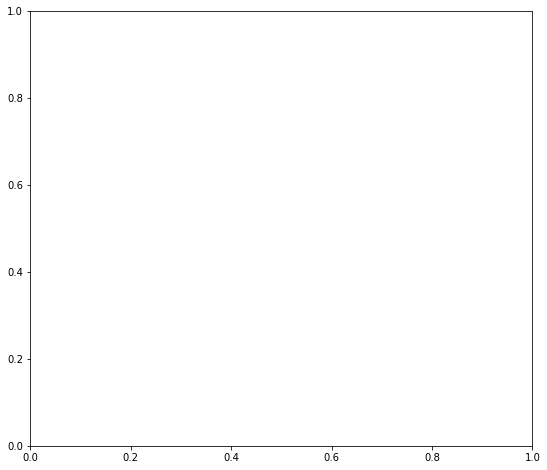

In [11]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(9, 8))
ax.plot(time_vals, temp[:].squeeze(), 'r', linewidth=2)
ax.set_ylabel(f'{temp.long_name} {temp.units}')
ax.set_xlabel('Forecast Time (UTC)')
ax.grid(True)